In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

import tensorflow as tf

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

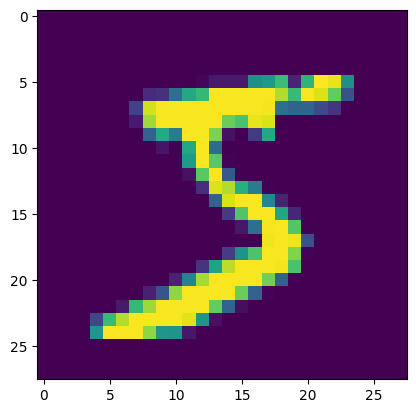

In [4]:
plt.imshow(X_train[0]);

In [5]:
X_train = X_train / 255. # (0,1) -> (0,2) -> (-1,1)

X_train = X_train.reshape(-1,28,28,1) * 2 - 1 # Generator will use tanh activation function in the last layer so we need to reshape X_train to fall between (-1,1)

In [6]:
X_train.min(), X_train.max() # Scaling for tanh

(-1.0, 1.0)

In [7]:
only_eights = X_train[y_train==8]

only_eights.shape

(5851, 28, 28, 1)

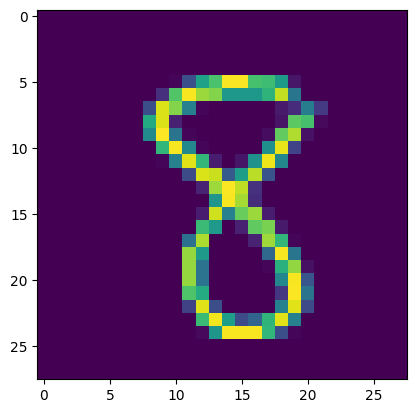

In [8]:
plt.imshow(only_eights[10]);

In [9]:
np.random.seed(101)

tf.random.set_seed(101)

codings_size = 100

In [10]:
784/8

98.0

In [11]:
generator = Sequential()

generator.add(Dense(units=7*7*128,input_shape=[codings_size]))

generator.add(Reshape(target_shape=[7,7,128]))

generator.add(BatchNormalization())

generator.add(Conv2DTranspose(filters=64,kernel_size=5,strides=2,padding='same',activation='relu'))

generator.add(BatchNormalization())

generator.add(Conv2DTranspose(filters=1,kernel_size=5,strides=2,padding='same',activation='tanh'))

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,705 (3.21 MB)

 Trainable params: 840,321 (3.21 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
discriminator = Sequential()

discriminator.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same',activation=LeakyReLU(negative_slope=0.3),input_shape=[28,28,1]))

discriminator.add(Dropout(0.4))

discriminator.add(Conv2D(filters=128,kernel_size=5,strides=2,padding='same',activation=LeakyReLU(negative_slope=0.3)))

discriminator.add(Dropout(0.5))

discriminator.add(Flatten())

discriminator.add(Dense(units=1,activation='sigmoid'))

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
GAN = Sequential([generator,discriminator])

GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       840,705 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,570 (4.02 MB)

 Trainable params: 1,053,186 (4.02 MB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
discriminator.compile(loss='binary_crossentropy',optimizer='adam')

discriminator.trainable = False # Discriminator should not be trained in the second phase of training

In [15]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

In [16]:
only_eights.shape

(5851, 28, 28, 1)

In [17]:
5851/32

182.84375

In [18]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(only_eights).shuffle(buffer_size=1000)

In [19]:
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [20]:
dataset = dataset.batch(batch_size=batch_size,drop_remainder=True).prefetch(1)

dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)>

In [21]:
epochs = 16



GAN.layers[0].layers # Generator model

[<Dense name=dense, built=True>,
 <Reshape name=reshape, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Conv2DTranspose name=conv2d_transpose, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Conv2DTranspose name=conv2d_transpose_1, built=True>]

In [22]:
GAN.layers[1].layers # Discriminator model

[<Conv2D name=conv2d, built=True>,
 <Dropout name=dropout, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense_1, built=True>]

In [23]:
GAN.layers[0].summary() # Generator model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,705 (3.21 MB)

 Trainable params: 840,321 (3.21 MB)

 Non-trainable params: 384 (1.50 KB)

In [24]:
GAN.layers[1].summary() # Discriminator model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 212,865 (831.50 KB)

In [25]:
generator, discriminator = GAN.layers



for i in range(epochs):

    print(f"Currently on epoch {i+1}")

    cnt = 0



    for batch in dataset:

        cnt += 1



        if cnt % 50 == 0:

            print(f"Currently on batch number {cnt} of {len(only_eights)//batch_size}")



        # Discriminator Training Phase

        noise = tf.random.normal([batch_size,codings_size])

        generated_images = generator(noise)

        X_fake_or_real = tf.concat([generated_images,tf.dtypes.cast(batch,tf.float32)],axis=0)

        y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)

        discriminator.trainable = True

        discriminator.train_on_batch(X_fake_or_real,y1)



        # Generator Training Phase

        noise = tf.random.normal([batch_size,codings_size])

        y2 = tf.constant([[1.0]]*batch_size) # This is because during generator training phase, we want the discriminator to believe that all images are real

        discriminator.trainable = False

        GAN.train_on_batch(noise,y2)

Currently on epoch 1


I0000 00:00:1729575713.844901      71 service.cc:145] XLA service 0x7b2d50004450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729575713.844945      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729575713.844949      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729575717.600723      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 2
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 3
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 4
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 5
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 6
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 7
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently on batch number 150 of 182
Currently on epoch 8
Currently on batch number 50 of 182
Currently on batch number 100 of 182
Currently 

In [26]:
noise = tf.random.normal([25,codings_size])

noise

<tf.Tensor: shape=(25, 100), dtype=float32, numpy=
array([[-0.40865913,  0.44354647,  0.9282068 , ..., -0.54818827,
        -0.56015706, -0.03947818],
       [-0.28240526,  0.11201911,  0.06736709, ..., -0.3463348 ,
        -0.27944535,  0.03415733],
       [ 1.4101707 ,  0.1465404 ,  0.85635245, ...,  0.12685382,
         0.7075477 , -1.3816402 ],
       ...,
       [-0.03546182, -0.0315    , -0.4692438 , ..., -1.0563817 ,
         1.5564253 , -0.8727594 ],
       [-1.3161707 , -0.938479  ,  1.3055367 , ..., -0.8644371 ,
         1.3266212 , -0.4453796 ],
       [-0.71772987,  1.1822628 ,  0.55732214, ..., -1.0385319 ,
        -0.15866233,  0.46159622]], dtype=float32)>

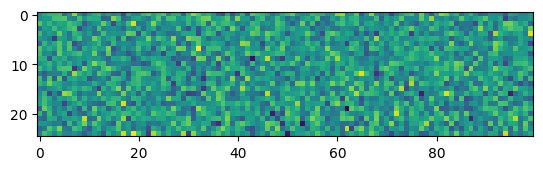

In [27]:
plt.imshow(noise);

In [28]:
images = generator(noise)

images.shape

TensorShape([25, 28, 28, 1])

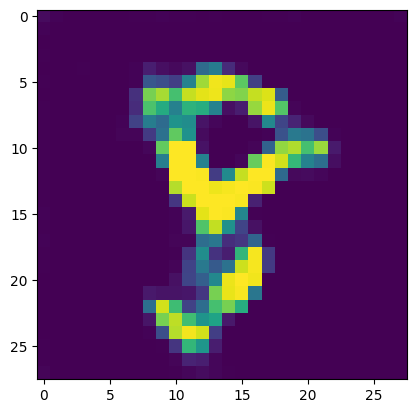

In [29]:
plt.imshow(images[0]);

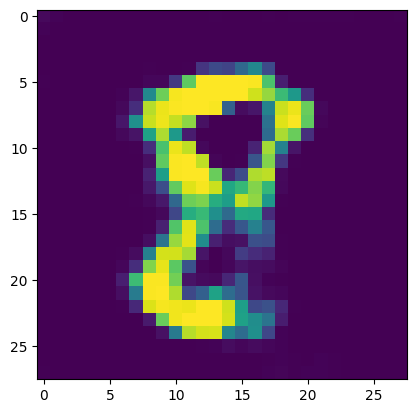

In [30]:
plt.imshow(images[5]);